In [1]:
from sklearn.datasets import make_classification as mk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
important_features = range(1,9,2)
total_features = [10,20,50]
#for i in important_features:
#    for feat in total_features:
#        data,target=mk(n_informative=i, n_redundant=0, n_repeated=0,n_features=feat,n_clusters_per_class=1,class_sep=2,shuffle=False)
#        data = pd.DataFrame(data)
        #data['target']=target
#        data.corr()
#        data.to_csv(r'C:\Users\Cristian\AAA Master_thesis\datasets\Verification\\'+str(i)+'_informative_'+str(feat)+'_features.csv',index=False)
#target= np.array(target)


In [2]:
import sklearn.metrics as metrics

METRICS ={
    'accuracy_score' : metrics.accuracy_score,
    'balanced_accuracy_score' : metrics.balanced_accuracy_score,
    #'top_k_accuracy_score' : metrics.top_k_accuracy_score,
    'f1_score' : metrics.f1_score,
    'roc_auc_score' : metrics.roc_auc_score
}

import dimensionality_reduction

D_R = {
    'pca':dimensionality_reduction.Pca,
    'tsne':dimensionality_reduction.Tsne,
    'Feature_agglomeration':dimensionality_reduction.Feature_agglomeration,
}

import classifiers

CLASSIFIERS = {
    #'Tree':classifiers.Tree_classifier,
    'Knn':classifiers.Knn_classifier,
    'Svc':classifiers.SVC_classifier,
    'Decision_tree':classifiers.DecisionTree_classifier,
    'Naive_Bayes':classifiers.Naive_Bayes_classifier
}

In [3]:
from os import listdir
from os.path import isfile, join

mypath=r'C:\Users\Cristian\AAA Master_thesis\datasets\Verification\\'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

source_data = [pd.read_csv(mypath+onlyfiles[i]) for i in range(len(onlyfiles))]

onlyfiles = np.array(onlyfiles).reshape(3,-1)
display(onlyfiles)

target= np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

array([['1_informative_10_features.csv', '1_informative_20_features.csv',
        '1_informative_50_features.csv', '3_informative_10_features.csv'],
       ['3_informative_20_features.csv', '3_informative_50_features.csv',
        '5_informative_10_features.csv', '5_informative_20_features.csv'],
       ['5_informative_50_features.csv', '7_informative_10_features.csv',
        '7_informative_20_features.csv', '7_informative_50_features.csv']],
      dtype='<U29')

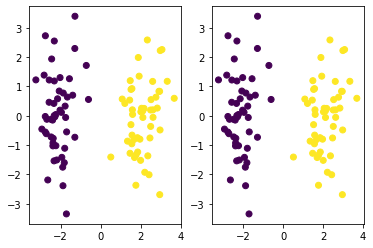

0.6235159130131764


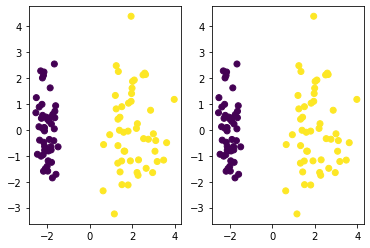

0.6084586354511308


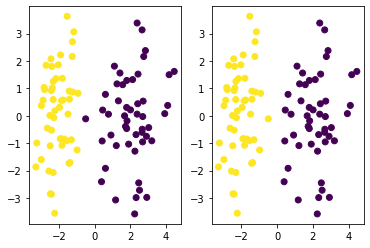

0.5235113347649761


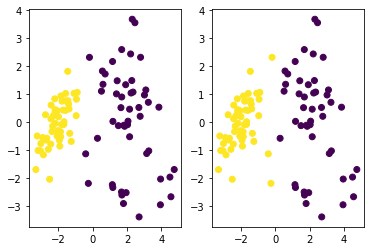

0.5625181617380959


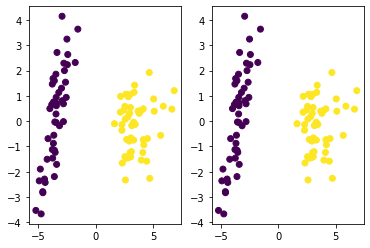

0.7063680844927681


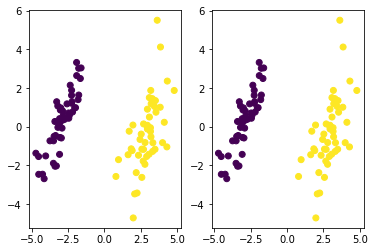

0.6569801576230719


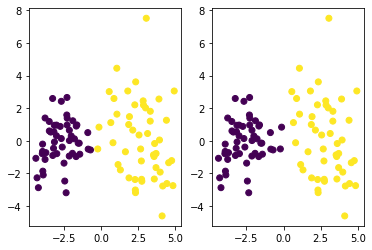

0.5439249870458631


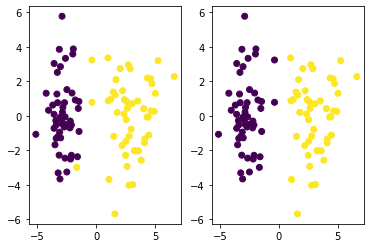

0.5499987615807814


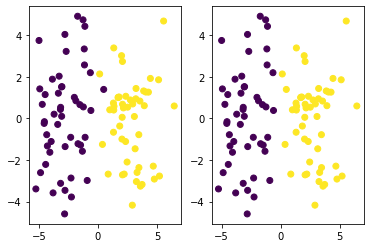

0.4863272611207891


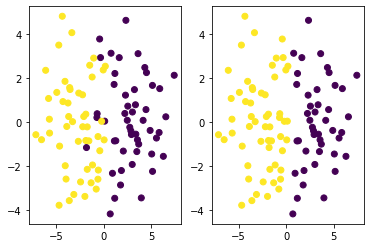

0.4508536851456151


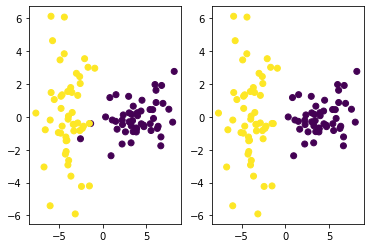

0.6067207485987245


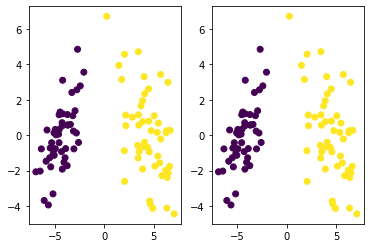

0.6650055274992894


In [4]:
from lime.lime_tabular import LimeTabularExplainer
from lime import submodular_pick
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

def pipeline(df,dr,metric):
    red = dr.get_reduced(df,{})

    cluster = KMeans(n_clusters=2, random_state=0)
    pred = np.array(cluster.fit_predict(red))

    cluster_accuracy_1 = len(target[target!=pred])
    pred = pred*-1+1
    cluster_accuracy_2 = len(target[target!=pred])
    cluster_accuracy = max(cluster_accuracy_1,cluster_accuracy_2)/red.shape[0]
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.scatter(red['x'],red['y'],c = target)
    ax2.scatter(red['x'],red['y'],c = pred)
    plt.show()

    silhouette = silhouette_score(red,pred)
    print(silhouette)
    
    X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.20, random_state=420)    
    trained_classifiers = [[c,CLASSIFIERS[c].get_model().fit(X_train,y_train)] for c in CLASSIFIERS.keys()]
    results=np.array([METRICS[metric](y_test,c[1].predict(X_test)) for c in trained_classifiers ])

    top_performer = CLASSIFIERS[list(CLASSIFIERS.keys())[np.argmax(results)]]
    
    rf = top_performer.get_model({}).fit(df, target)

    extended_df = df.copy()
    extended_df['target']=target
    
    explainer = LimeTabularExplainer(df.to_numpy(), feature_names=df.columns, class_names=['target'], 
                                         categorical_features=[], verbose=False, mode='classification',
                                         discretize_continuous=False)
    
    sp_obj = submodular_pick.SubmodularPick(data = df.to_numpy(),explainer=explainer,
                                                predict_fn=rf.predict_proba ,sample_size=100,
                                                num_exps_desired=30,top_labels=2)
    
    W=pd.DataFrame([dict(this.as_list()) for this in sp_obj.explanations])

    #Sort matrix
    W=W.fillna(0)
    
    #Order by abs mean
    order = W.apply(lambda c: c.abs().sum(),axis = 0)
    ordered = np.argsort(-order)
    cols = [W.columns[i] for i in ordered]
    W = W[cols]
    #Reduce W if too many columns
    if(W.shape[1]>10):
        W=W.iloc[:, 0:10]
    return cluster_accuracy,silhouette, top_performer, np.max(results), W.columns

dr = dimensionality_reduction.Pca
metric = 'balanced_accuracy_score'

results = []
for d in source_data:
    results.append(pipeline(d,dr,metric))
    

In [31]:
results

[(1.0,
  0.6235159130131764,
  classifiers.Knn_classifier,
  1.0,
  Index(['0', '7', '4', '1', '8', '5', '6', '9', '2', '3'], dtype='object')),
 (1.0,
  0.6084586354511308,
  classifiers.Knn_classifier,
  1.0,
  Index(['0', '16', '10', '17', '18', '12', '4', '15', '7', '11'], dtype='object')),
 (0.99,
  0.5235113347649761,
  classifiers.DecisionTree_classifier,
  1.0,
  Index(['0', '8', '26', '17', '13', '41', '11', '31', '44', '25'], dtype='object')),
 (0.97,
  0.5625181617380959,
  classifiers.DecisionTree_classifier,
  1.0,
  Index(['1', '9', '6', '7', '0', '2', '5', '3', '8', '4'], dtype='object')),
 (1.0,
  0.7063680844927681,
  classifiers.Knn_classifier,
  1.0,
  Index(['1', '2', '0', '5', '11', '8', '12', '15', '16', '13'], dtype='object')),
 (1.0,
  0.6569801576230719,
  classifiers.Knn_classifier,
  1.0,
  Index(['2', '1', '48', '20', '18', '9', '0', '35', '29', '10'], dtype='object')),
 (0.98,
  0.5439249870458631,
  classifiers.Knn_classifier,
  1.0,
  Index(['2', '0', '4',

In [9]:
pd.DataFrame(results,columns=['cluster_accuracy','silhouette', 'top_performer', 'classification_accuracy','top_results']).to_csv(r'dataset_analysis_results')


NameError: name 'results' is not defined

In [5]:
data = pd.read_csv('dataset_analysis_results',index_col=0)
data['top_results']=data['top_results'].apply(lambda x:x[7:-18].replace('\'','').replace(',', ''))
data['top_results']=data['top_results'].apply(lambda x:x.split(' '))
data['important_features']=np.repeat(important_features,len(total_features))
data['total_features']=total_features*len(important_features)
data

,cluster_accuracy,silhouette,top_performer,cllassification_accuracy,top_results,important_features,total_features
0,1.00,0.623516,<class 'classifiers.Knn_classifier'>,1.00000,"[0, 7, 4, 1, 8, 5, 6, 9, 2, 3]",1,10
1,1.00,0.608459,<class 'classifiers.Knn_classifier'>,1.00000,"[0, 16, 10, 17, 18, 12, 4, 15, 7, 11]",1,20
2,0.99,0.523511,<class 'classifiers.DecisionTree_classifier'>,1.00000,"[0, 8, 26, 17, 13, 41, 11, 31, 44, 25]",1,50
3,0.97,0.562518,<class 'classifiers.DecisionTree_classifier'>,1.00000,"[1, 9, 6, 7, 0, 2, 5, 3, 8, 4]",3,10
4,1.00,0.706368,<class 'classifiers.Knn_classifier'>,1.00000,"[1, 2, 0, 5, 11, 8, 12, 15, 16, 13]",3,20
5,1.00,0.656980,<class 'classifiers.Knn_classifier'>,1.00000,"[2, 1, 48, 20, 18, 9, 0, 35, 29, 10]",3,50
6,0.98,0.543925,<class 'classifiers.Knn_classifier'>,1.00000,"[2, 0, 4, 3, 1, 8, 9, 7, 6, 5]",5,10
7,0.97,0.549999,<class 'classifiers.Knn_classifier'>,1.00000,"[3, 1, 4, 12, 17, 16, 9, 11, 19, 0]",5,20
8,0.99,0.486327,<class 'classifiers.Naive_Bayes_classifier'>,0.96875,"[1, 4, 7, 38, 10, 23, 8, 18, 41, 2]",5,50
9,0.94,0.450854,<class 'classifiers.Knn_classifier'>,1.00000,"[6, 5, 3, 0, 1, 2, 4, 8, 9, 7]",7,10


In [6]:
top_index = 7
test = data['top_results'][0]
print(test)

def count(x,max_val):
    r=0
    for v in x:
        if(int(v)>=max_val):
            return r
        r+=1

lime_explanation_accuracy = []
i=0
indx = [1,3,5,7]
for t in data['top_results']:
    print(count(t,indx[int(i/3)]),indx[int(i/3)])
    lime_explanation_accuracy.append(count(t,indx[int(i/3)])/indx[int(i/3)])
    i+=1
    
data['lime_explanation_accuracy']=lime_explanation_accuracy
data

['0', '7', '4', '1', '8', '5', '6', '9', '2', '3']
1 1
1 1
1 1
1 3
3 3
2 3
5 5
3 5
2 5
7 7
6 7
6 7


,cluster_accuracy,silhouette,top_performer,cllassification_accuracy,top_results,important_features,total_features,lime_explanation_accuracy
0,1.00,0.623516,<class 'classifiers.Knn_classifier'>,1.00000,"[0, 7, 4, 1, 8, 5, 6, 9, 2, 3]",1,10,1.000000
1,1.00,0.608459,<class 'classifiers.Knn_classifier'>,1.00000,"[0, 16, 10, 17, 18, 12, 4, 15, 7, 11]",1,20,1.000000
2,0.99,0.523511,<class 'classifiers.DecisionTree_classifier'>,1.00000,"[0, 8, 26, 17, 13, 41, 11, 31, 44, 25]",1,50,1.000000
3,0.97,0.562518,<class 'classifiers.DecisionTree_classifier'>,1.00000,"[1, 9, 6, 7, 0, 2, 5, 3, 8, 4]",3,10,0.333333
4,1.00,0.706368,<class 'classifiers.Knn_classifier'>,1.00000,"[1, 2, 0, 5, 11, 8, 12, 15, 16, 13]",3,20,1.000000
5,1.00,0.656980,<class 'classifiers.Knn_classifier'>,1.00000,"[2, 1, 48, 20, 18, 9, 0, 35, 29, 10]",3,50,0.666667
6,0.98,0.543925,<class 'classifiers.Knn_classifier'>,1.00000,"[2, 0, 4, 3, 1, 8, 9, 7, 6, 5]",5,10,1.000000
7,0.97,0.549999,<class 'classifiers.Knn_classifier'>,1.00000,"[3, 1, 4, 12, 17, 16, 9, 11, 19, 0]",5,20,0.600000
8,0.99,0.486327,<class 'classifiers.Naive_Bayes_classifier'>,0.96875,"[1, 4, 7, 38, 10, 23, 8, 18, 41, 2]",5,50,0.400000
9,0.94,0.450854,<class 'classifiers.Knn_classifier'>,1.00000,"[6, 5, 3, 0, 1, 2, 4, 8, 9, 7]",7,10,1.000000


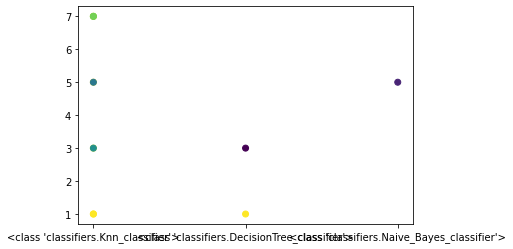

In [161]:
x=data['top_performer']
y=data['important_features']
plt.scatter(x,y,c=lime_explanation_accuracy)

In [163]:
display(data.groupby(by =['top_performer','important_features']).mean())
display(data.groupby(by =['top_performer','total_features']).mean())

cluster_accuracy  \
top_performer                                 important_features                     
<class 'classifiers.DecisionTree_classifier'> 1                           0.990000   
                                              3                           0.970000   
<class 'classifiers.Knn_classifier'>          1                           1.000000   
                                              3                           1.000000   
                                              5                           0.975000   
                                              7                           0.973333   
<class 'classifiers.Naive_Bayes_classifier'>  5                           0.990000   

                                                                  silhouette  \
top_performer                                 important_features               
<class 'classifiers.DecisionTree_classifier'> 1                     0.523511   
                                              3                     0.562518   
<class 'classifiers.Knn_classifier'>          1                     0.615987   
                                              3                     0.681674   
                                              5                     0.546962   
                                              7                     0.574193   
<class 'classifiers.Naive_Bayes_classifier'>  5                     0.486327   

                                                                  cllassification_accuracy  \
top_performer                                 important_features                             
<class 'classifiers.DecisionTree_classifier'> 1                                    1.00000   
                                              3                                    1.00000   
<class 'classifiers.Knn_classifier'>          1                                    1.00000   
                                              3                                    1.00000   
                                              5                                    1.00000   
                                              7                                    1.00000   
<class 'classifiers.Naive_Bayes_classifier'>  5                                    0.96875   

                                                                  total_features  \
top_performer                                 important_features                   
<class 'classifiers.DecisionTree_classifier'> 1                        50.000000   
                                              3                        10.000000   
<class 'classifiers.Knn_classifier'>          1                        15.000000   
                                              3                        35.000000   
                                              5                        15.000000   
                                              7                        26.666667   
<class 'classifiers.Naive_Bayes_classifier'>  5                        50.000000   

                                                                  lime_explanation_accuracy  
top_performer                                 important_features                             
<class 'classifiers.DecisionTree_classifier'> 1                                    1.000000  
                                              3                                    0.333333  
<class 'classifiers.Knn_classifier'>          1                                    1.000000  
                                              3                                    0.833333  
                                              5                                    0.800000  
                                              7                                    0.904762  
<class 'classifiers.Naive_Bayes_classifier'>  5                                    0.400000

cluster_accuracy  \
top_performer                                 total_features                     
<class 'classifiers.DecisionTree_classifier'> 10                      0.970000   
                                              50                      0.990000   
<class 'classifiers.Knn_classifier'>          10                      0.973333   
                                              20                      0.987500   
                                              50                      1.000000   
<class 'classifiers.Naive_Bayes_classifier'>  50                      0.990000   

                                                              silhouette  \
top_performer                                 total_features               
<class 'classifiers.DecisionTree_classifier'> 10                0.562518   
                                              50                0.523511   
<class 'classifiers.Knn_classifier'>          10                0.539432   
                                              20                0.617887   
                                              50                0.660993   
<class 'classifiers.Naive_Bayes_classifier'>  50                0.486327   

                                                              cllassification_accuracy  \
top_performer                                 total_features                             
<class 'classifiers.DecisionTree_classifier'> 10                               1.00000   
                                              50                               1.00000   
<class 'classifiers.Knn_classifier'>          10                               1.00000   
                                              20                               1.00000   
                                              50                               1.00000   
<class 'classifiers.Naive_Bayes_classifier'>  50                               0.96875   

                                                              important_features  \
top_performer                                 total_features                       
<class 'classifiers.DecisionTree_classifier'> 10                        3.000000   
                                              50                        1.000000   
<class 'classifiers.Knn_classifier'>          10                        4.333333   
                                              20                        4.000000   
                                              50                        5.000000   
<class 'classifiers.Naive_Bayes_classifier'>  50                        5.000000   

                                                              lime_explanation_accuracy  
top_performer                                 total_features                             
<class 'classifiers.DecisionTree_classifier'> 10                               0.333333  
                                              50                               1.000000  
<class 'classifiers.Knn_classifier'>          10                               1.000000  
                                              20                               0.864286  
                                              50                               0.761905  
<class 'classifiers.Naive_Bayes_classifier'>  50                               0.400000

In [153]:
data.corr()

,cluster_accuracy,silhouette,cllassification_accuracy,important_features,total_features,lime_explanation_accuracy
cluster_accuracy,1.000000,0.731486,-0.085855,-0.509372,0.474670,0.130914
silhouette,0.731486,1.000000,0.396172,-0.227386,0.106735,0.205802
cllassification_accuracy,-0.085855,0.396172,1.000000,-0.134840,-0.413919,0.518323
important_features,-0.509372,-0.227386,-0.134840,1.000000,0.000000,-0.134093
total_features,0.474670,0.106735,-0.413919,0.000000,1.000000,-0.213653
lime_explanation_accuracy,0.130914,0.205802,0.518323,-0.134093,-0.213653,1.000000


In [8]:
def display_feature_matrix(d):
    fig, ax = plt.subplots()
    m = np.reshape(d.to_numpy(),(4,-1))
    ax.imshow(m,vmin=0, vmax=1)

    lbx = ax.get_xticklabels()
    lby = ax.get_yticklabels()

    ax.set_ylabel('total_features')
    plt.xticks(ticks = [0,1,2],labels=[str(i) for i in total_features])

    ax.set_xlabel('important_features')
    plt.yticks(ticks = [0,1,2,3],labels=[str(i) for i in important_features])
    
    col = lambda x: 'black' if (x > 0.5) else 'white'
    for i in range(len(important_features)):
        for j in range(len(total_features)):
            text = ax.text(j, i, round(m[i, j],2),
                           ha="center", va="center", color=col(m[i, j]))    
    

0.8095238095238096


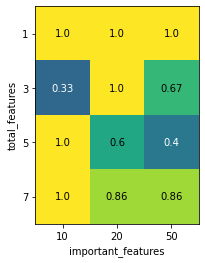

In [9]:
display_feature_matrix(data['lime_explanation_accuracy'])
print(data['lime_explanation_accuracy'].mean())

In [61]:
from lime.lime_tabular import LimeTabularExplainer
from lime import submodular_pick
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

def new_pipeline(df,dr,metric,imp,tot,classifier):
    red = dr.get_reduced(df,{})

    cluster = KMeans(n_clusters=2, random_state=0)
    pred = np.array(cluster.fit_predict(red))

    cluster_accuracy_1 = len(target[target!=pred])
    pred = pred*-1+1
    cluster_accuracy_2 = len(target[target!=pred])
    cluster_accuracy = max(cluster_accuracy_1,cluster_accuracy_2)/red.shape[0]

    silhouette = silhouette_score(red,pred)
    
    X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.20, random_state=420)    
    
    trained_classifier=classifier.get_model().fit(X_train,y_train)
    result = METRICS[metric](y_test,trained_classifier.predict(X_test))

    rf = classifier.get_model({}).fit(df, target)

    extended_df = df.copy()
    extended_df['target']=target
    
    explainer = LimeTabularExplainer(df.to_numpy(), feature_names=df.columns, class_names=['target'], 
                                         categorical_features=[], verbose=False, mode='classification',
                                         discretize_continuous=False)
    
    sp_obj = submodular_pick.SubmodularPick(data = df.to_numpy(),explainer=explainer,
                                                predict_fn=rf.predict_proba ,sample_size=100,
                                                num_exps_desired=30,top_labels=2)
    
    W=pd.DataFrame([dict(this.as_list()) for this in sp_obj.explanations])

    #Sort matrix
    W=W.fillna(0)
    
    #Order by abs mean
    order = W.apply(lambda c: c.abs().sum(),axis = 0)
    ordered = np.argsort(-order)
    cols = [W.columns[i] for i in ordered]
    W = W[cols]
    #Reduce W if too many columns
    if(W.shape[1]>10):
        W=W.iloc[:, 0:10]
    
    return cluster_accuracy,silhouette, classifier, result, W.columns,imp,tot    

In [ ]:
dr = dimensionality_reduction.Pca
metric = 'balanced_accuracy_score'

results = []
indx_imp = [1,3,5,7]
for i in range(0,len(source_data)):
    for c in CLASSIFIERS.values():
        print(i,indx_imp[int(i/3)],source_data[i].shape[1],c)
        results.append(new_pipeline(source_data[i],dr,metric,indx_imp[int(i/3)],source_data[i].shape[1],c))


In [10]:
results

[(1.0,
  0.6235159130131764,
  classifiers.Knn_classifier,
  1.0,
  Index(['0', '7', '4', '1', '8', '2', '9', '6', '5', '3'], dtype='object'),
  1,
  10),
 (1.0,
  0.6235159130131764,
  classifiers.SVC_classifier,
  1.0,
  Index(['0', '4', '7', '9', '2', '1', '5', '6', '3', '8'], dtype='object'),
  1,
  10),
 (1.0,
  0.6235159130131764,
  classifiers.DecisionTree_classifier,
  1.0,
  Index(['0', '4', '3', '6', '9', '2', '1', '7', '5', '8'], dtype='object'),
  1,
  10),
 (1.0,
  0.6235159130131764,
  classifiers.Naive_Bayes_classifier,
  1.0,
  Index(['0', '9', '4', '2', '5', '6', '8', '7', '1', '3'], dtype='object'),
  1,
  10),
 (1.0,
  0.6084586354511308,
  classifiers.Knn_classifier,
  1.0,
  Index(['0', '16', '10', '18', '17', '12', '4', '7', '11', '15'], dtype='object'),
  1,
  20),
 (1.0,
  0.6084586354511308,
  classifiers.SVC_classifier,
  1.0,
  Index(['0', '4', '7', '10', '12', '18', '19', '16', '6', '17'], dtype='object'),
  1,
  20),
 (1.0,
  0.6084586354511308,
  classifie

In [46]:
pd.DataFrame(results,columns=['cluster_accuracy','silhouette', 'classifier', 'classification_accuracy','top_results','important_features','total_features']).to_csv(r'classifiers_analysis_results')


In [52]:
data_all = pd.read_csv('classifiers_analysis_results',index_col=0)
data_all['top_results']=data_all['top_results'].apply(lambda x:x[7:-18].replace('\'','').replace(',', ''))
data_all['top_results']=data_all['top_results'].apply(lambda x:x.split(' '))
data_all

,cluster_accuracy,silhouette,classifier,classification_accuracy,top_results,important_features,total_features
0,1.00,0.623516,<class 'classifiers.Knn_classifier'>,1.00000,"[0, 7, 4, 1, 8, 2, 9, 6, 5, 3]",1,10
1,1.00,0.623516,<class 'classifiers.SVC_classifier'>,1.00000,"[0, 4, 7, 9, 2, 1, 5, 6, 3, 8]",1,10
2,1.00,0.623516,<class 'classifiers.DecisionTree_classifier'>,1.00000,"[0, 4, 3, 6, 9, 2, 1, 7, 5, 8]",1,10
3,1.00,0.623516,<class 'classifiers.Naive_Bayes_classifier'>,1.00000,"[0, 9, 4, 2, 5, 6, 8, 7, 1, 3]",1,10
4,1.00,0.608459,<class 'classifiers.Knn_classifier'>,1.00000,"[0, 16, 10, 18, 17, 12, 4, 7, 11, 15]",1,20
5,1.00,0.608459,<class 'classifiers.SVC_classifier'>,1.00000,"[0, 4, 7, 10, 12, 18, 19, 16, 6, 17]",1,20
6,1.00,0.608459,<class 'classifiers.DecisionTree_classifier'>,1.00000,"[0, 17, 18, 14, 10, 6, 7, 12, 15, 3]",1,20
7,1.00,0.608459,<class 'classifiers.Naive_Bayes_classifier'>,1.00000,"[0, 19, 16, 14, 13, 8, 7, 18, 9, 12]",1,20
8,0.99,0.523511,<class 'classifiers.Knn_classifier'>,0.96875,"[0, 20, 25, 30, 29, 26, 2, 11, 9, 36]",1,50
9,0.99,0.523511,<class 'classifiers.SVC_classifier'>,0.87500,"[0, 20, 3, 25, 24, 13, 44, 27, 7, 45]",1,50


In [53]:
def count(x,max_val):
    r=0
    for v in x:
        if(int(v)>=max_val):
            return r
        r+=1

lime_explanation_accuracy = []
i=0

for t,i in zip(data_all['top_results'],data_all['important_features']):
    lime_explanation_accuracy.append(count(t,i)/i)
    
data_all['lime_explanation_accuracy']=lime_explanation_accuracy
data_all

,cluster_accuracy,silhouette,classifier,classification_accuracy,top_results,important_features,total_features,lime_explanation_accuracy
0,1.00,0.623516,<class 'classifiers.Knn_classifier'>,1.00000,"[0, 7, 4, 1, 8, 2, 9, 6, 5, 3]",1,10,1.000000
1,1.00,0.623516,<class 'classifiers.SVC_classifier'>,1.00000,"[0, 4, 7, 9, 2, 1, 5, 6, 3, 8]",1,10,1.000000
2,1.00,0.623516,<class 'classifiers.DecisionTree_classifier'>,1.00000,"[0, 4, 3, 6, 9, 2, 1, 7, 5, 8]",1,10,1.000000
3,1.00,0.623516,<class 'classifiers.Naive_Bayes_classifier'>,1.00000,"[0, 9, 4, 2, 5, 6, 8, 7, 1, 3]",1,10,1.000000
4,1.00,0.608459,<class 'classifiers.Knn_classifier'>,1.00000,"[0, 16, 10, 18, 17, 12, 4, 7, 11, 15]",1,20,1.000000
5,1.00,0.608459,<class 'classifiers.SVC_classifier'>,1.00000,"[0, 4, 7, 10, 12, 18, 19, 16, 6, 17]",1,20,1.000000
6,1.00,0.608459,<class 'classifiers.DecisionTree_classifier'>,1.00000,"[0, 17, 18, 14, 10, 6, 7, 12, 15, 3]",1,20,1.000000
7,1.00,0.608459,<class 'classifiers.Naive_Bayes_classifier'>,1.00000,"[0, 19, 16, 14, 13, 8, 7, 18, 9, 12]",1,20,1.000000
8,0.99,0.523511,<class 'classifiers.Knn_classifier'>,0.96875,"[0, 20, 25, 30, 29, 26, 2, 11, 9, 36]",1,50,1.000000
9,0.99,0.523511,<class 'classifiers.SVC_classifier'>,0.87500,"[0, 20, 3, 25, 24, 13, 44, 27, 7, 45]",1,50,1.000000


In [34]:
#multiple random arrays
random_dataframe = pd.DataFrame()

random_count = 50000

import random

for j in range(random_count):
    random_results = []

    #Compare results with random baseline
    for i in important_features:
        for t in total_features:
            r = list(range(0,t))
            random.shuffle(r)
            random_results.append(count(r,i)/i)
    random_dataframe[j] = random_results

random_dataframe = pd.DataFrame(random_dataframe.to_numpy().mean(axis =1))

    
combs =[]
for i in important_features:
    for t in total_features:
        combs.append([i,t])

combs = np.array(combs)
random_dataframe['important_features'] = combs[:,0]
random_dataframe['total_features'] = combs[:,1]

random_dataframe

,0,important_features,total_features
0,0.099920,1,10
1,0.049080,1,20
2,0.020100,1,50
3,0.125213,3,10
4,0.055547,3,20
5,0.020173,3,50
6,0.167860,5,10
7,0.063576,5,20
8,0.021784,5,50
9,0.251534,7,10


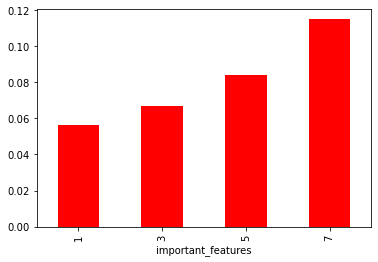

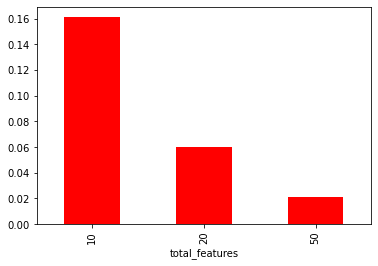

In [35]:
#Compare mean accuracy
means =random_dataframe.groupby(by=['important_features'])[0].mean()
c=np.repeat(['red','green','blue','yellow'],4)
means.plot.bar(color =c)
plt.show()
means =random_dataframe.groupby(by=['total_features'])[0].mean()
c=np.repeat(['red','green','blue','yellow'],4)
means.plot.bar(color =c)
plt.show()

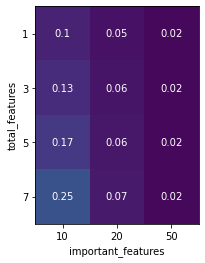

In [36]:
#print(np.reshape(random_dataframe[0].to_numpy(),(4,-1)))
display_feature_matrix(random_dataframe[0])

In [7]:
import random
random_results = []

print()
#Compare results with random baseline
for i,t in zip(data_all['important_features'],data_all['total_features']):
    r = list(range(0,t))
    random.shuffle(r)
    random_results.append(count(r,i)/i)
data_all['random_results']=random_results
data_all



,cluster_accuracy,silhouette,classifier,classification_accuracy,top_results,important_features,total_features,lime_explanation_accuracy,random_results
0,1.00,0.623516,<class 'classifiers.Knn_classifier'>,1.00000,"[0, 7, 4, 1, 8, 2, 9, 6, 5, 3]",1,10,1.000000,0.000000
1,1.00,0.623516,<class 'classifiers.SVC_classifier'>,1.00000,"[0, 4, 7, 9, 2, 1, 5, 6, 3, 8]",1,10,1.000000,0.000000
2,1.00,0.623516,<class 'classifiers.DecisionTree_classifier'>,1.00000,"[0, 4, 3, 6, 9, 2, 1, 7, 5, 8]",1,10,1.000000,0.000000
3,1.00,0.623516,<class 'classifiers.Naive_Bayes_classifier'>,1.00000,"[0, 9, 4, 2, 5, 6, 8, 7, 1, 3]",1,10,1.000000,0.000000
4,1.00,0.608459,<class 'classifiers.Knn_classifier'>,1.00000,"[0, 16, 10, 18, 17, 12, 4, 7, 11, 15]",1,20,1.000000,0.000000
5,1.00,0.608459,<class 'classifiers.SVC_classifier'>,1.00000,"[0, 4, 7, 10, 12, 18, 19, 16, 6, 17]",1,20,1.000000,0.000000
6,1.00,0.608459,<class 'classifiers.DecisionTree_classifier'>,1.00000,"[0, 17, 18, 14, 10, 6, 7, 12, 15, 3]",1,20,1.000000,0.000000
7,1.00,0.608459,<class 'classifiers.Naive_Bayes_classifier'>,1.00000,"[0, 19, 16, 14, 13, 8, 7, 18, 9, 12]",1,20,1.000000,0.000000
8,0.99,0.523511,<class 'classifiers.Knn_classifier'>,0.96875,"[0, 20, 25, 30, 29, 26, 2, 11, 9, 36]",1,50,1.000000,0.000000
9,0.99,0.523511,<class 'classifiers.SVC_classifier'>,0.87500,"[0, 20, 3, 25, 24, 13, 44, 27, 7, 45]",1,50,1.000000,1.000000


In [6]:
1/10*1/9 *2

0.022222222222222223

In [8]:
data_all.corr()

,cluster_accuracy,silhouette,classification_accuracy,important_features,total_features,lime_explanation_accuracy,random_results
cluster_accuracy,1.000000,0.731486,-0.029214,-5.093716e-01,4.746703e-01,0.286461,-0.506831
silhouette,0.731486,1.000000,0.278756,-2.273865e-01,1.067354e-01,0.235670,-0.436652
classification_accuracy,-0.029214,0.278756,1.000000,4.588315e-02,-1.911504e-01,0.117342,-0.354802
important_features,-0.509372,-0.227386,0.045883,1.000000e+00,-2.570647e-16,-0.443945,0.137216
total_features,0.474670,0.106735,-0.191150,-2.570647e-16,1.000000e+00,-0.175955,-0.189190
lime_explanation_accuracy,0.286461,0.235670,0.117342,-4.439454e-01,-1.759551e-01,1.000000,-0.110191
random_results,-0.506831,-0.436652,-0.354802,1.372157e-01,-1.891897e-01,-0.110191,1.000000


In [54]:
s= data_all.groupby(by=['classifier']).corr()['lime_explanation_accuracy']
pd.DataFrame(s)

lime_explanation_accuracy
classifier                                                                                        
<class 'classifiers.DecisionTree_classifier'> cluster_accuracy                            0.504616
                                              silhouette                                  0.262455
                                              classification_accuracy                    -0.135663
                                              important_features                         -0.724285
                                              total_features                             -0.163154
                                              lime_explanation_accuracy                   1.000000
<class 'classifiers.Knn_classifier'>          cluster_accuracy                            0.130914
                                              silhouette                                  0.205802
                                              classification_accuracy                     0.728446
                                              important_features                         -0.134093
                                              total_features                             -0.213653
                                              lime_explanation_accuracy                   1.000000
<class 'classifiers.Naive_Bayes_classifier'>  cluster_accuracy                            0.174371
                                              silhouette                                  0.190752
                                              classification_accuracy                     0.048632
                                              important_features                         -0.316652
                                              total_features                             -0.159503
                                              lime_explanation_accuracy                   1.000000
<class 'classifiers.SVC_classifier'>          cluster_accuracy                            0.362892
                                              silhouette                                  0.371803
                                              classification_accuracy                     0.176524
                                              important_features                         -0.684303
                                              total_features                             -0.236187
                                              lime_explanation_accuracy                   1.000000

cluster_accuracy  \
classifier                                    total_features                     
<class 'classifiers.DecisionTree_classifier'> 10                        0.9725   
                                              20                        0.9875   
                                              50                        0.9950   
<class 'classifiers.Knn_classifier'>          10                        0.9725   
                                              20                        0.9875   
                                              50                        0.9950   
<class 'classifiers.Naive_Bayes_classifier'>  10                        0.9725   
                                              20                        0.9875   
                                              50                        0.9950   
<class 'classifiers.SVC_classifier'>          10                        0.9725   
                                              20                        0.9875   
                                              50                        0.9950   

                                                              silhouette  \
classifier                                    total_features               
<class 'classifiers.DecisionTree_classifier'> 10                0.545203   
                                              20                0.617887   
                                              50                0.582956   
<class 'classifiers.Knn_classifier'>          10                0.545203   
                                              20                0.617887   
                                              50                0.582956   
<class 'classifiers.Naive_Bayes_classifier'>  10                0.545203   
                                              20                0.617887   
                                              50                0.582956   
<class 'classifiers.SVC_classifier'>          10                0.545203   
                                              20                0.617887   
                                              50                0.582956   

                                                              classification_accuracy  \
classifier                                    total_features                            
<class 'classifiers.DecisionTree_classifier'> 10                             0.968750   
                                              20                             0.992188   
                                              50                             0.976562   
<class 'classifiers.Knn_classifier'>          10                             0.984375   
                                              20                             1.000000   
                                              50                             0.976562   
<class 'classifiers.Naive_Bayes_classifier'>  10                             0.968750   
                                              20                             1.000000   
                                              50                             0.992188   
<class 'classifiers.SVC_classifier'>          10                             0.984375   
                                              20                             1.000000   
                                              50                             0.921875   

                                                              important_features  \
classifier                                    total_features                       
<class 'classifiers.DecisionTree_classifier'> 10                               4   
                                              20                               4   
                                              50                               4   
<class 'classifiers.Knn_classifier'>          10                               4   
                                              20                               4   
             

"x=np.repeat(['Tree','Knn','Naive','Svc'],3)\ny= [10,20,50]*4\nc=means['lime_explanation_accuracy'].tolist()\nplt.scatter(x,y,c=c,s =80)#,c=data_all['lime_explanation_accuracy']"

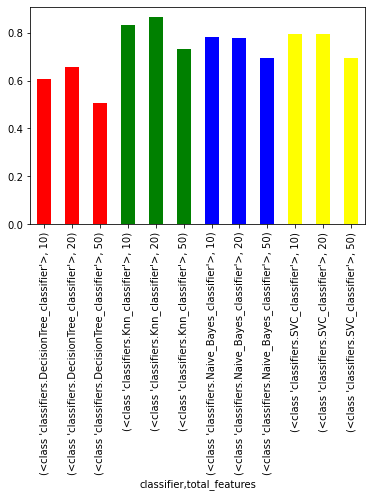

In [24]:
display(data_all.groupby(by=['classifier','total_features']).mean())
#Compare mean accuracy
means =data_all.groupby(by=['classifier','total_features'])['lime_explanation_accuracy'].mean()
c=np.repeat(['red','green','blue','yellow'],3)
means.plot.bar(color =c)

"""x=np.repeat(['Tree','Knn','Naive','Svc'],3)
y= [10,20,50]*4
c=means['lime_explanation_accuracy'].tolist()
plt.scatter(x,y,c=c,s =80)#,c=data_all['lime_explanation_accuracy']"""

cluster_accuracy  \
classifier                                    important_features                     
<class 'classifiers.DecisionTree_classifier'> 1                           0.996667   
                                              3                           0.990000   
                                              5                           0.980000   
                                              7                           0.973333   
<class 'classifiers.Knn_classifier'>          1                           0.996667   
                                              3                           0.990000   
                                              5                           0.980000   
                                              7                           0.973333   
<class 'classifiers.Naive_Bayes_classifier'>  1                           0.996667   
                                              3                           0.990000   
                                              5                           0.980000   
                                              7                           0.973333   
<class 'classifiers.SVC_classifier'>          1                           0.996667   
                                              3                           0.990000   
                                              5                           0.980000   
                                              7                           0.973333   

                                                                  silhouette  \
classifier                                    important_features               
<class 'classifiers.DecisionTree_classifier'> 1                     0.585162   
                                              3                     0.641955   
                                              5                     0.526750   
                                              7                     0.574193   
<class 'classifiers.Knn_classifier'>          1                     0.585162   
                                              3                     0.641955   
                                              5                     0.526750   
                                              7                     0.574193   
<class 'classifiers.Naive_Bayes_classifier'>  1                     0.585162   
                                              3                     0.641955   
                                              5                     0.526750   
                                              7                     0.574193   
<class 'classifiers.SVC_classifier'>          1                     0.585162   
                                              3                     0.641955   
                                              5                     0.526750   
                                              7                     0.574193   

                                                                  classification_accuracy  \
classifier                                    important_features                            
<class 'classifiers.DecisionTree_classifier'> 1                                  1.000000   
                                              3                                  0.989583   
                                              5                                  0.927083   
                                              7                                  1.000000   
<class 'classifiers.Knn_classifier'>          1                                  0.989583   
                                              3                                  0.979167   
                                              5                                  0.979167   
                                              7                                  1.000000   
<class 'classifiers.Naive_Bayes_classifier'>  1                                  1.000000   
                                              3      

"\nx=np.repeat(['Tree','Knn','Naive','Svc'],4)\ny= [1,3,5,7]*4\nprint(len(x),len(y))\nc=means['lime_explanation_accuracy'].tolist()\nplt.scatter(x,y,c=c,s =80)#,c=data_all['lime_explanation_accuracy']"

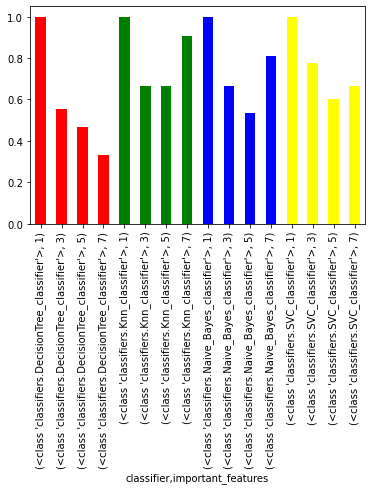

In [22]:
display(data_all.groupby(by=['classifier','important_features']).mean())
#Compare mean accuracy
means =data_all.groupby(by=['classifier','important_features'])['lime_explanation_accuracy'].mean()
c=np.repeat(['red','green','blue','yellow'],4)
means.plot.bar(color =c)
"""
x=np.repeat(['Tree','Knn','Naive','Svc'],4)
y= [1,3,5,7]*4
print(len(x),len(y))
c=means['lime_explanation_accuracy'].tolist()
plt.scatter(x,y,c=c,s =80)#,c=data_all['lime_explanation_accuracy']"""

In [57]:
temp  = ['cluster_accuracy','silhouette','classifier' ,'classification_accuracy','important_features','total_features','lime_explanation_accuracy']
data_all[temp].to_csv(r'classifiers_analysis_results.csv',index=False)

<class 'classifiers.Knn_classifier'>
0.8095238095238096


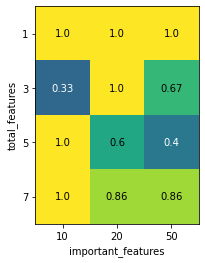

<class 'classifiers.SVC_classifier'>
0.7611111111111111


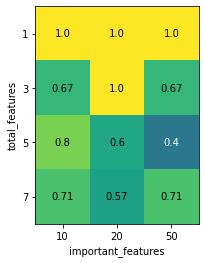

<class 'classifiers.DecisionTree_classifier'>
0.5888888888888889


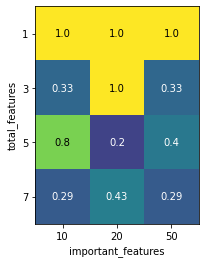

<class 'classifiers.Naive_Bayes_classifier'>
0.7523809523809523


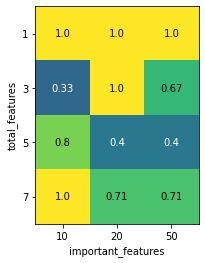

In [55]:
for classifier in data_all['classifier'].unique():
    d = data_all[data_all['classifier']==classifier]
    #display(pd.DataFrame(d))
    print(classifier)
    display_feature_matrix(d['lime_explanation_accuracy'])
    print(d['lime_explanation_accuracy'].mean())
    plt.show()

0.7404761904761904


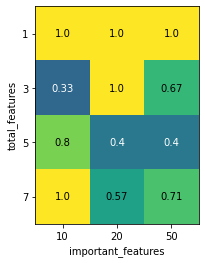

In [80]:
corr_selection = []

for temp in source_data:
    t=temp.copy()
    t['target'] = target
    c = t.corr()
    scores = np.abs(c['target'][:-1])
    sel = np.array((-scores).argsort()[:10])
    #print('np.argmax(scores)',sel)
    corr_selection.append(sel)
    #plt.imshow(c)
    #plt.show()

#data['corr'] = corr_selection
temp=0
corr_score = []
for i in important_features:
    for t in total_features:
        #print(corr_selection[temp],count(corr_selection[temp],i)/i)
        corr_score.append(count(corr_selection[temp],i)/i)
        temp = temp+1
display_feature_matrix(pd.DataFrame(corr_score))  
print(np.array(corr_score).mean())


0.7063492063492065


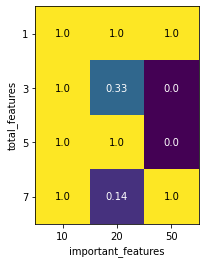

In [81]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

RFE_selection = []
for X in source_data:
    y=target
    #estimator = SVR(kernel="linear")
    estimator= LogisticRegression()

    selector = RFE(estimator, n_features_to_select=10)
    selector = selector.fit(X, y)
    #print(selector.ranking_)
    RFE_selection.append((selector.ranking_).argsort()[:10])

temp=0
RFE_score = []
for i in important_features:
    for t in total_features:
        #print(corr_selection[temp],count(corr_selection[temp],i)/i)
        RFE_score.append(count(RFE_selection[temp],i)/i)
        temp = temp+1
display_feature_matrix(pd.DataFrame(RFE_score))   
print(np.array(RFE_score).mean())

0.7333333333333334


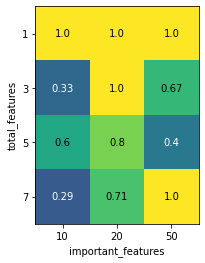

In [83]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

feature_selector_selection = []
for X in source_data:
    y=target
    est = LogisticRegression()
    sfs = SelectFromModel(est).fit(X, y)
    #print( sfs.estimator_.coef_)
    arr = (-sfs.estimator_.coef_).argsort()[:10]
    #print(arr)
    #print(sfs.get_support())
    feature_selector_selection.append((-np.abs(sfs.estimator_.coef_)).argsort()[:10].ravel())
feature_selector_selection

temp=0
feature_selector_score = []
for i in important_features:
    for t in total_features:
        #print(corr_selection[temp],count(corr_selection[temp],i)/i)
        feature_selector_score.append(count(feature_selector_selection[temp],i)/i)
        temp = temp+1
display_feature_matrix(pd.DataFrame(feature_selector_score))   
print(np.array(feature_selector_score).mean())

In [87]:
from lime.lime_tabular import LimeTabularExplainer
from lime import submodular_pick
#from sklearn.cluster import Knn
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

dr = dimensionality_reduction.Pca
metric = 'balanced_accuracy_score'

results = []
indx_imp = [1,3,5,7]
for s in range(5):
    print(s)
    for i in range(0,len(source_data)):
        for c in CLASSIFIERS.values():
            #print(i,indx_imp[int(i/3)],source_data[i].shape[1],c)
            results.append(new_pipeline(source_data[i],dr,metric,indx_imp[int(i/3)],source_data[i].shape[1],c))
results

0
1
2
3
4


[(1.0,
  0.6235159130131764,
  classifiers.Knn_classifier,
  1.0,
  Index(['0', '7', '4', '1', '8', '2', '9', '6', '5', '3'], dtype='object'),
  1,
  10),
 (1.0,
  0.6235159130131764,
  classifiers.SVC_classifier,
  1.0,
  Index(['0', '4', '7', '1', '9', '2', '5', '6', '3', '8'], dtype='object'),
  1,
  10),
 (1.0,
  0.6235159130131764,
  classifiers.DecisionTree_classifier,
  1.0,
  Index(['0', '3', '9', '8', '4', '7', '2', '1', '5', '6'], dtype='object'),
  1,
  10),
 (1.0,
  0.6235159130131764,
  classifiers.Naive_Bayes_classifier,
  1.0,
  Index(['0', '9', '4', '1', '2', '5', '8', '6', '7', '3'], dtype='object'),
  1,
  10),
 (1.0,
  0.6084586354511308,
  classifiers.Knn_classifier,
  1.0,
  Index(['0', '16', '10', '18', '17', '4', '12', '15', '11', '7'], dtype='object'),
  1,
  20),
 (1.0,
  0.6084586354511308,
  classifiers.SVC_classifier,
  1.0,
  Index(['0', '4', '7', '10', '12', '18', '19', '16', '6', '8'], dtype='object'),
  1,
  20),
 (1.0,
  0.6084586354511308,
  classifier

In [88]:
pd.DataFrame(results,columns=['cluster_accuracy','silhouette', 'classifier', 'classification_accuracy','top_results','important_features','total_features']).to_csv(r'multiple_runs_classifiers_analysis_results')


In [90]:
data_all_repeated = pd.read_csv('multiple_runs_classifiers_analysis_results',index_col=0)
data_all_repeated['top_results']=data_all_repeated['top_results'].apply(lambda x:x[7:-18].replace('\'','').replace(',', ''))
data_all_repeated['top_results']=data_all_repeated['top_results'].apply(lambda x:x.split(' '))
data_all_repeated

,cluster_accuracy,silhouette,classifier,classification_accuracy,top_results,important_features,total_features
0,1.00,0.623516,<class 'classifiers.Knn_classifier'>,1.0,"[0, 7, 4, 1, 8, 2, 9, 6, 5, 3]",1,10
1,1.00,0.623516,<class 'classifiers.SVC_classifier'>,1.0,"[0, 4, 7, 1, 9, 2, 5, 6, 3, 8]",1,10
2,1.00,0.623516,<class 'classifiers.DecisionTree_classifier'>,1.0,"[0, 3, 9, 8, 4, 7, 2, 1, 5, 6]",1,10
3,1.00,0.623516,<class 'classifiers.Naive_Bayes_classifier'>,1.0,"[0, 9, 4, 1, 2, 5, 8, 6, 7, 3]",1,10
4,1.00,0.608459,<class 'classifiers.Knn_classifier'>,1.0,"[0, 16, 10, 18, 17, 4, 12, 15, 11, 7]",1,20
...,...,...,...,...,...,...,...
235,0.98,0.606721,<class 'classifiers.Naive_Bayes_classifier'>,1.0,"[1, 0, 5, 6, 4, 19, 16, 7, 3, 18]",7,20
236,1.00,0.665006,<class 'classifiers.Knn_classifier'>,1.0,"[1, 3, 6, 5, 2, 4, 13, 38, 0, 21]",7,50
237,1.00,0.665006,<class 'classifiers.SVC_classifier'>,1.0,"[1, 6, 3, 5, 2, 13, 4, 32, 16, 38]",7,50
238,1.00,0.665006,<class 'classifiers.DecisionTree_classifier'>,1.0,"[1, 6, 4, 13, 23, 9, 8, 27, 30, 19]",7,50


In [91]:
def count(x,max_val):
    r=0
    for v in x:
        if(int(v)>=max_val):
            return r
        r+=1

lime_explanation_accuracy = []
i=0

for t,i in zip(data_all_repeated['top_results'],data_all_repeated['important_features']):
    print(t,i)
    lime_explanation_accuracy.append(count(t,i)/i)
    
data_all_repeated['lime_explanation_accuracy']=lime_explanation_accuracy
data_all_repeated

['0', '7', '4', '1', '8', '2', '9', '6', '5', '3'] 1
['0', '4', '7', '1', '9', '2', '5', '6', '3', '8'] 1
['0', '3', '9', '8', '4', '7', '2', '1', '5', '6'] 1
['0', '9', '4', '1', '2', '5', '8', '6', '7', '3'] 1
['0', '16', '10', '18', '17', '4', '12', '15', '11', '7'] 1
['0', '4', '7', '10', '12', '18', '19', '16', '6', '8'] 1
['0', '8', '1', '3', '5', '4', '13', '7', '16', '14'] 1
['0', '6', '3', '13', '14', '4', '18', '7', '17', '9'] 1
['0', '20', '25', '30', '29', '26', '2', '36', '9', '24'] 1
['0', '20', '3', '25', '24', '13', '7', '27', '44', '10'] 1
['0', '18', '29', '19', '27', '43', '46', '17', '40', '8'] 1
['0', '20', '30', '3', '47', '41', '38', '44', '29', '13'] 1
['1', '4', '6', '2', '8', '0', '5', '9', '7', '3'] 3
['1', '0', '4', '7', '3', '5', '2', '6', '9', '8'] 3
['1', '5', '4', '2', '8', '9', '0', '7', '6', '3'] 3
['1', '3', '2', '7', '4', '5', '6', '0', '9', '8'] 3
['1', '2', '0', '11', '8', '5', '12', '15', '16', '13'] 3
['1', '2', '0', '7', '6', '5', '9', '4', '16'

,cluster_accuracy,silhouette,classifier,classification_accuracy,top_results,important_features,total_features,lime_explanation_accuracy
0,1.00,0.623516,<class 'classifiers.Knn_classifier'>,1.0,"[0, 7, 4, 1, 8, 2, 9, 6, 5, 3]",1,10,1.000000
1,1.00,0.623516,<class 'classifiers.SVC_classifier'>,1.0,"[0, 4, 7, 1, 9, 2, 5, 6, 3, 8]",1,10,1.000000
2,1.00,0.623516,<class 'classifiers.DecisionTree_classifier'>,1.0,"[0, 3, 9, 8, 4, 7, 2, 1, 5, 6]",1,10,1.000000
3,1.00,0.623516,<class 'classifiers.Naive_Bayes_classifier'>,1.0,"[0, 9, 4, 1, 2, 5, 8, 6, 7, 3]",1,10,1.000000
4,1.00,0.608459,<class 'classifiers.Knn_classifier'>,1.0,"[0, 16, 10, 18, 17, 4, 12, 15, 11, 7]",1,20,1.000000
...,...,...,...,...,...,...,...,...
235,0.98,0.606721,<class 'classifiers.Naive_Bayes_classifier'>,1.0,"[1, 0, 5, 6, 4, 19, 16, 7, 3, 18]",7,20,0.714286
236,1.00,0.665006,<class 'classifiers.Knn_classifier'>,1.0,"[1, 3, 6, 5, 2, 4, 13, 38, 0, 21]",7,50,0.857143
237,1.00,0.665006,<class 'classifiers.SVC_classifier'>,1.0,"[1, 6, 3, 5, 2, 13, 4, 32, 16, 38]",7,50,0.714286
238,1.00,0.665006,<class 'classifiers.DecisionTree_classifier'>,1.0,"[1, 6, 4, 13, 23, 9, 8, 27, 30, 19]",7,50,0.428571


In [104]:
#Here we can see that the decision tree is changing decisions, but it doesn't really impact the score
for classifier in data_all['classifier'].unique():
    d = data_all_repeated[data_all_repeated['classifier']==classifier]
    display(d)

,cluster_accuracy,silhouette,classifier,classification_accuracy,top_results,important_features,total_features,lime_explanation_accuracy
0,1.00,0.623516,<class 'classifiers.Knn_classifier'>,1.00000,"[0, 7, 4, 1, 8, 2, 9, 6, 5, 3]",1,10,1.000000
4,1.00,0.608459,<class 'classifiers.Knn_classifier'>,1.00000,"[0, 16, 10, 18, 17, 4, 12, 15, 11, 7]",1,20,1.000000
8,0.99,0.523511,<class 'classifiers.Knn_classifier'>,0.96875,"[0, 20, 25, 30, 29, 26, 2, 36, 9, 24]",1,50,1.000000
12,0.97,0.562518,<class 'classifiers.Knn_classifier'>,0.93750,"[1, 4, 6, 2, 8, 0, 5, 9, 7, 3]",3,10,0.333333
16,1.00,0.706368,<class 'classifiers.Knn_classifier'>,1.00000,"[1, 2, 0, 11, 8, 5, 12, 15, 16, 13]",3,20,1.000000
20,1.00,0.656980,<class 'classifiers.Knn_classifier'>,1.00000,"[2, 1, 48, 20, 18, 9, 35, 10, 29, 0]",3,50,0.666667
24,0.98,0.543925,<class 'classifiers.Knn_classifier'>,1.00000,"[2, 0, 4, 3, 1, 9, 8, 6, 5, 7]",5,10,1.000000
28,0.97,0.549999,<class 'classifiers.Knn_classifier'>,1.00000,"[3, 1, 4, 12, 17, 16, 9, 11, 19, 0]",5,20,0.600000
32,0.99,0.486327,<class 'classifiers.Knn_classifier'>,0.93750,"[4, 1, 7, 47, 42, 23, 2, 15, 28, 8]",5,50,0.400000
36,0.94,0.450854,<class 'classifiers.Knn_classifier'>,1.00000,"[6, 5, 3, 0, 1, 2, 4, 8, 9, 7]",7,10,1.000000


,cluster_accuracy,silhouette,classifier,classification_accuracy,top_results,important_features,total_features,lime_explanation_accuracy
1,1.00,0.623516,<class 'classifiers.SVC_classifier'>,1.00000,"[0, 4, 7, 1, 9, 2, 5, 6, 3, 8]",1,10,1.000000
5,1.00,0.608459,<class 'classifiers.SVC_classifier'>,1.00000,"[0, 4, 7, 10, 12, 18, 19, 16, 6, 8]",1,20,1.000000
9,0.99,0.523511,<class 'classifiers.SVC_classifier'>,0.87500,"[0, 20, 3, 25, 24, 13, 7, 27, 44, 10]",1,50,1.000000
13,0.97,0.562518,<class 'classifiers.SVC_classifier'>,0.93750,"[1, 0, 4, 7, 3, 5, 2, 6, 9, 8]",3,10,0.666667
17,1.00,0.706368,<class 'classifiers.SVC_classifier'>,1.00000,"[1, 2, 0, 7, 6, 5, 9, 4, 16, 12]",3,20,1.000000
21,1.00,0.656980,<class 'classifiers.SVC_classifier'>,0.90625,"[1, 2, 20, 12, 49, 29, 34, 6, 8, 0]",3,50,0.666667
25,0.98,0.543925,<class 'classifiers.SVC_classifier'>,1.00000,"[0, 2, 4, 1, 9, 8, 5, 3, 7, 6]",5,10,0.800000
29,0.97,0.549999,<class 'classifiers.SVC_classifier'>,1.00000,"[3, 1, 4, 12, 11, 17, 9, 0, 8, 2]",5,20,0.600000
33,0.99,0.486327,<class 'classifiers.SVC_classifier'>,0.90625,"[4, 1, 7, 23, 27, 38, 47, 41, 8, 33]",5,50,0.400000
37,0.94,0.450854,<class 'classifiers.SVC_classifier'>,1.00000,"[6, 5, 3, 0, 1, 8, 7, 9, 4, 2]",7,10,0.714286


,cluster_accuracy,silhouette,classifier,classification_accuracy,top_results,important_features,total_features,lime_explanation_accuracy
2,1.00,0.623516,<class 'classifiers.DecisionTree_classifier'>,1.00000,"[0, 3, 9, 8, 4, 7, 2, 1, 5, 6]",1,10,1.000000
6,1.00,0.608459,<class 'classifiers.DecisionTree_classifier'>,1.00000,"[0, 8, 1, 3, 5, 4, 13, 7, 16, 14]",1,20,1.000000
10,0.99,0.523511,<class 'classifiers.DecisionTree_classifier'>,1.00000,"[0, 18, 29, 19, 27, 43, 46, 17, 40, 8]",1,50,1.000000
14,0.97,0.562518,<class 'classifiers.DecisionTree_classifier'>,1.00000,"[1, 5, 4, 2, 8, 9, 0, 7, 6, 3]",3,10,0.333333
18,1.00,0.706368,<class 'classifiers.DecisionTree_classifier'>,0.96875,"[1, 0, 2, 9, 12, 7, 5, 15, 16, 13]",3,20,1.000000
22,1.00,0.656980,<class 'classifiers.DecisionTree_classifier'>,1.00000,"[1, 44, 41, 35, 48, 37, 8, 24, 38, 3]",3,50,0.333333
26,0.98,0.543925,<class 'classifiers.DecisionTree_classifier'>,1.00000,"[0, 2, 4, 9, 8, 7, 1, 6, 5, 3]",5,10,0.600000
30,0.97,0.549999,<class 'classifiers.DecisionTree_classifier'>,1.00000,"[3, 14, 1, 13, 15, 12, 0, 4, 11, 17]",5,20,0.200000
34,0.99,0.486327,<class 'classifiers.DecisionTree_classifier'>,0.90625,"[4, 1, 6, 32, 17, 2, 11, 13, 16, 35]",5,50,0.400000
38,0.94,0.450854,<class 'classifiers.DecisionTree_classifier'>,1.00000,"[5, 6, 1, 3, 9, 2, 8, 7, 4, 0]",7,10,0.571429


,cluster_accuracy,silhouette,classifier,classification_accuracy,top_results,important_features,total_features,lime_explanation_accuracy
3,1.00,0.623516,<class 'classifiers.Naive_Bayes_classifier'>,1.00000,"[0, 9, 4, 1, 2, 5, 8, 6, 7, 3]",1,10,1.000000
7,1.00,0.608459,<class 'classifiers.Naive_Bayes_classifier'>,1.00000,"[0, 6, 3, 13, 14, 4, 18, 7, 17, 9]",1,20,1.000000
11,0.99,0.523511,<class 'classifiers.Naive_Bayes_classifier'>,1.00000,"[0, 20, 30, 3, 47, 41, 38, 44, 29, 13]",1,50,1.000000
15,0.97,0.562518,<class 'classifiers.Naive_Bayes_classifier'>,1.00000,"[1, 3, 2, 7, 4, 5, 6, 0, 9, 8]",3,10,0.333333
19,1.00,0.706368,<class 'classifiers.Naive_Bayes_classifier'>,1.00000,"[1, 2, 0, 5, 3, 9, 17, 13, 19, 12]",3,20,1.000000
23,1.00,0.656980,<class 'classifiers.Naive_Bayes_classifier'>,1.00000,"[1, 2, 12, 20, 7, 8, 23, 49, 31, 22]",3,50,0.666667
27,0.98,0.543925,<class 'classifiers.Naive_Bayes_classifier'>,0.87500,"[2, 0, 1, 3, 9, 5, 8, 7, 6, 4]",5,10,0.800000
31,0.97,0.549999,<class 'classifiers.Naive_Bayes_classifier'>,1.00000,"[3, 1, 11, 2, 12, 0, 5, 7, 17, 10]",5,20,0.400000
35,0.99,0.486327,<class 'classifiers.Naive_Bayes_classifier'>,0.96875,"[1, 4, 7, 10, 38, 23, 8, 18, 33, 2]",5,50,0.400000
39,0.94,0.450854,<class 'classifiers.Naive_Bayes_classifier'>,1.00000,"[5, 6, 3, 4, 2, 1, 0, 9, 7, 8]",7,10,1.000000


<class 'classifiers.Knn_classifier'>
0.8095238095238096


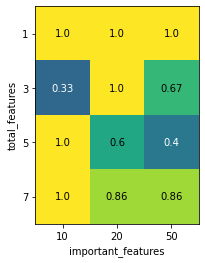

<class 'classifiers.SVC_classifier'>
0.7611111111111111


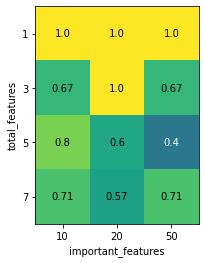

<class 'classifiers.DecisionTree_classifier'>
0.5904761904761905


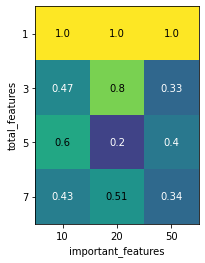

<class 'classifiers.Naive_Bayes_classifier'>
0.7509523809523809


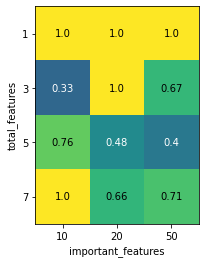

In [103]:
means = data_all_repeated.groupby(by=['classifier','important_features','total_features'])['lime_explanation_accuracy'].mean()
for classifier in data_all['classifier'].unique():
    d = data_all_repeated[data_all_repeated['classifier']==classifier]
    #display(pd.DataFrame(d))
    d=d.groupby(by=['classifier','important_features','total_features']).mean()
    print(classifier)
    display_feature_matrix(d['lime_explanation_accuracy'])
    print(d['lime_explanation_accuracy'].mean())
    plt.show()

0.8063492063492063


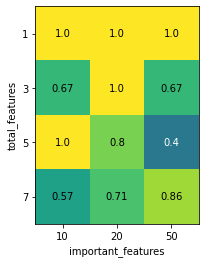

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

mdl = LinearRegression()
ffw_sel=[]
for X in source_data:
    X = X.to_numpy()
    y= target
    n= X.shape[0]

    it, best = range(X.shape[1]), []

    for i in range(X.shape[1]):
        scores = []
        for j in it:
            tmpX = X[:, best + [j]] # use the best feature(s) and iteratate over the rest
            mdl.fit(tmpX, y)
            dy = y - mdl.predict(tmpX) # y - y_pred
            scores.append(1.0/n * np.dot(dy, dy))
        m = it[np.argmin(scores)] # finds the index of the smallest cost
        best.append(m)
        it = np.setdiff1d(it, m) # removes m from it since it's already used

    ffw_sel.append(best[:10])

temp=0
ffw_sel_score = []
for i in important_features:
    for t in total_features:
        #print(corr_selection[temp],count(corr_selection[temp],i)/i)
        ffw_sel_score.append(count(ffw_sel[temp],i)/i)
        temp = temp+1
display_feature_matrix(pd.DataFrame(ffw_sel_score))
print(np.array(ffw_sel_score).mean())

In [ ]:
'YE OLD CODE'

import pandas as pd
import numpy as np
class Dataset_holder():
    def get_dataset(self, dataset):
        if dataset == 'test':
            url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

            df = pd.read_csv(url, names=['sepal length', 'sepal width', 'petal length', 'petal width','species'])
            #
            df = df.drop('species',axis = 1)
            #display(df)

            #One hot encode obvious categorical values
            df= pd.get_dummies(df,  prefix = "one_hot")
            
            #Get Obvious categorical
            cat = np.array([list(df.columns).index(col) for col in df.columns if (str(col).startswith('one'))],dtype=int)            
            #display(cat)
            return df
        
    def get_data_cat(self, dataset):
        if dataset == 'test':
            url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

            df = pd.read_csv(url, names=['sepal length', 'sepal width', 'petal length', 'petal width','species'])

            df = df.drop('species',axis = 1)
            #One hot encode obvious categorical values
            df= pd.get_dummies(df,  prefix = "one_hot")
            #display(df)            
            #Get Obvious categorical
            cat = np.array([list(df.columns).index(col) for col in df.columns if (str(col).startswith('one'))])            
            
            #display(cat)
                        
            return df,cat
        
d = Dataset_holder();
            
d.get_data_cat('test')

Stuff to do:

Program test:
- make process very clear for user
- Ask them to think aloud (like/hate/hard/easy)
- RECORD the tests!!
- Not testing UI, but some specific thing
- Artificial dataset has a baseline expectation
- DON'T COMPLICATE THE EXPERIMENT

Do demo -> play around/ask questions -> give them the experimental setup (no questions anymore) -> ICE-T

add something that shows a progress in the navigation

TEST if a person can use my tool and explain what are the best features that separate this cluster from the rest

Experimental results:
- 3 datasets with increasing difficulty
- are they able to determine the best feature separators?
- Track what DR+Classifier they used
- Save what they are doing

Start writing the thesis:
- NO systematic literature review
- Start with technical part/results
- Technical part is the core, the rest is mostly context/motivation


### Should i remove the tree classifier?

Important features
- How many features you think are important?
- Do you think the histograms agree with the explanation?

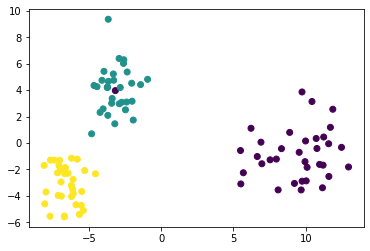

In [63]:
data,target=mk(n_informative=5, n_redundant=0, n_repeated=0,n_features=30,n_classes=3,n_clusters_per_class=1,class_sep=4,shuffle=False)

dr = dimensionality_reduction.Pca
red = dr.get_reduced(data,{})
plt.scatter(red['x'],red['y'],c=target)
target

pd.DataFrame(data).to_csv('Three_clusters.csv',index = False)

1_informative_10_features.csv


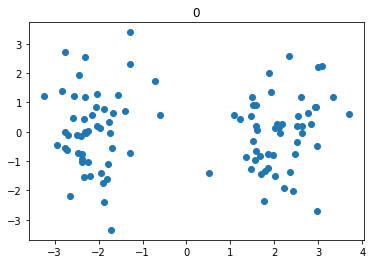

1_informative_20_features.csv


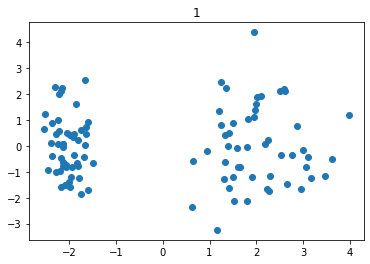

1_informative_50_features.csv


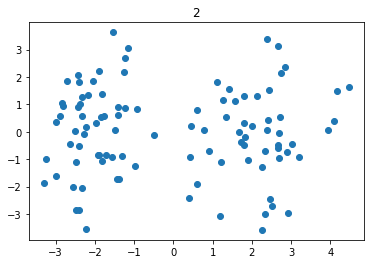

3_informative_10_features.csv


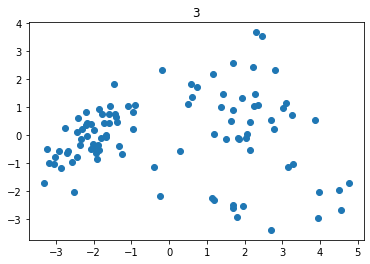

3_informative_20_features.csv


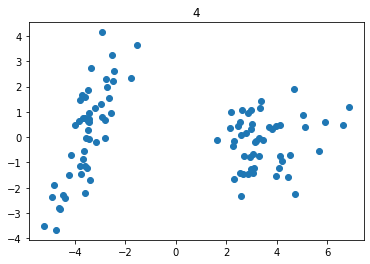

3_informative_50_features.csv


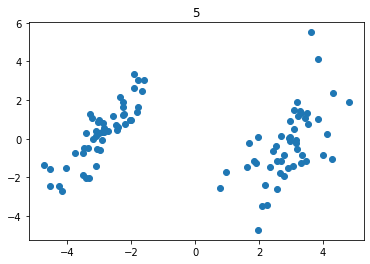

5_informative_10_features.csv


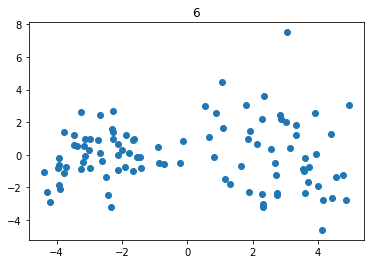

5_informative_20_features.csv


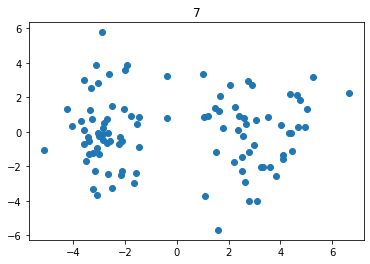

5_informative_50_features.csv


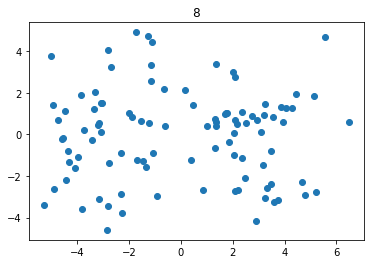

7_informative_10_features.csv


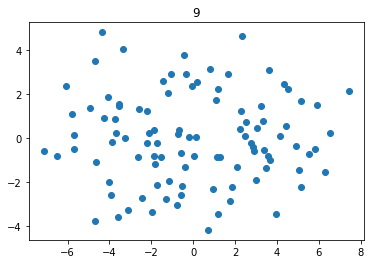

7_informative_20_features.csv


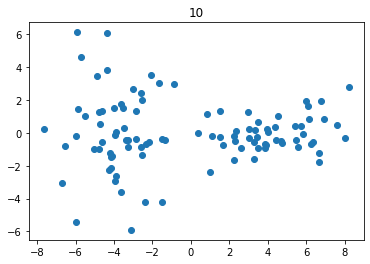

7_informative_50_features.csv


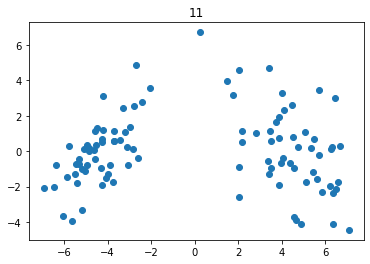

In [22]:
dr = dimensionality_reduction.Pca

#i=0
from os import listdir
from os.path import isfile, join

mypath=r'C:\Users\Cristian\AAA Master_thesis\datasets\Verification\\'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

source_data = [pd.read_csv(mypath+onlyfiles[i]) for i in range(len(onlyfiles))]

onlyfiles = np.array(onlyfiles).reshape(3,-1).ravel()

for i in range(len(onlyfiles)):
    d = pd.read_csv(mypath+onlyfiles[i])
    print(onlyfiles[i])
    red = dr.get_reduced(d,{})
    plt.scatter(red['x'],red['y'])
    plt.title(i)
    plt.show()
    #i=i+1